In [1]:
from math import sqrt 
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import LSTM,GRU,SimpleRNN,Conv1D,Dropout,Bidirectional,Permute,Multiply,Flatten,MaxPooling1D,concatenate
from keras.layers import Input
import numpy as np
import pandas as pd
from keras.models import *
from keras.layers import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pydot
import keras.backend as K
from keras import regularizers
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'#将图片保存为矢量图

plt.rcParams['font.sans-serif']=['FangSong_GB2312'] #用来正常显示中文
plt.rcParams['axes.unicode_minus']=False  #用来正常显示负号

Using TensorFlow backend.


#### 2.2 读取数据
写两个读取数据的函数，excel2train以及excel2test，excel2train从原始excel文件中读取前80%个数据点作为训练集，excel2test从原始excel文件中读取后20%个点作为验证集

In [2]:
def excel2train(path):
    data = pd.read_csv(path,index_col=0)
    data = np.array(data)
#     scaler = MinMaxScaler()
#     data = scaler.fit_transform(data)
    return data

In [23]:
path1 = 'C:/Users/shamrockyj/Desktop/毕设：航空发动机智能运维与健康管理/毕业论文/故障数据/VMD后数据/34_22/' #数据路径
path2 = 'C:/Users/shamrockyj/Desktop/毕设：航空发动机智能运维与健康管理/毕业论文/故障数据/VMD后数据/34_44/' #数据路径
path3 = 'C:/Users/shamrockyj/Desktop/毕设：航空发动机智能运维与健康管理/毕业论文/故障数据/VMD后数据/57_22/' #数据路径
path4 = 'C:/Users/shamrockyj/Desktop/毕设：航空发动机智能运维与健康管理/毕业论文/故障数据/VMD后数据/57_44/' #数据路径

#### 训练数据

In [63]:
traindata_0 = excel2train(path4+'57_44_正常.csv')
traindata_1 = excel2train(path4+'57_44_断齿.csv')
traindata_2 = excel2train(path4+'57_44_缺齿.csv')
traindata_3 = excel2train(path4+'57_44_磨损.csv')
traindata_4 = excel2train(path4+'57_44_裂纹.csv')
traindata_5 = excel2train(path4+'57_44_偏心.csv')

In [64]:
traindata_0.shape

(3072000, 15)

In [65]:
length = 1024

In [66]:
channels = traindata_0.shape[1]
traindata_0 = traindata_0.reshape(-1,length,channels)
traindata_1 = traindata_1.reshape(-1,length,channels)
traindata_2 = traindata_2.reshape(-1,length,channels)
traindata_3 = traindata_3.reshape(-1,length,channels)
traindata_4 = traindata_4.reshape(-1,length,channels)
traindata_5 = traindata_5.reshape(-1,length,channels)

In [67]:
#利用随机数种子对数据和标签进行同顺序打乱
randnum = 200
np.random.seed(randnum)
np.random.shuffle(traindata_0)
np.random.seed(randnum)
np.random.shuffle(traindata_1)
np.random.seed(randnum)
np.random.shuffle(traindata_2)
np.random.seed(randnum)
np.random.shuffle(traindata_3)
np.random.seed(randnum)
np.random.shuffle(traindata_4)
np.random.seed(randnum)
np.random.shuffle(traindata_5)

In [68]:
traindata_0.shape

(3000, 1024, 15)

In [69]:
test_1 = traindata_0[2500:]
test_2 = traindata_1[2500:]
test_3 = traindata_2[2500:]
test_4 = traindata_3[2500:]
test_5 = traindata_4[2500:]
test_6 = traindata_5[2500:]

In [70]:
test_x = np.vstack([test_1,test_2,test_3,test_4,test_5,test_6])  #四列数据纵向堆叠

生成训练数据集1024*15的矩阵及贴标签

In [71]:
features = 6
#定义标签生成函数
def LabelGeneration(train0,train1,train2,train3,train4,train5):
    y0 = np.full(train0.shape[0],0)
    y1 = np.full(train1.shape[0],1)
    y2 = np.full(train2.shape[0],2)
    y3 = np.full(train3.shape[0],3)
    y4 = np.full(train4.shape[0],4)
    y5 = np.full(train5.shape[0],5)
    
#     each_num = X//features #这里的X为数据总数
    y = []
    for i in range(features):
#         locals()['y'+str(i)] = np.full(each_num,i)
        y = np.append(y,locals()['y'+str(i)])
    return y

In [72]:
test_y = LabelGeneration(test_1,test_2,test_3,test_4,test_5,test_6)

In [73]:
#利用随机数种子对数据和标签进行同顺序打乱
randnum = 100
np.random.seed(randnum)
np.random.shuffle(test_x)
np.random.seed(randnum)
np.random.shuffle(test_y)

#将标签转换为独热码格式
from keras.utils.np_utils import to_categorical
one_hot_test_y = to_categorical(test_y)
print(one_hot_test_y)

#查看标签中每一个故障类别的个数
label = [np.argmax(item)+1 for item in one_hot_test_y]
label
s=set()#定义集合
for i in label:#循环列表中的元素
    if i not in s:#如果i不在集合中
        s.add(i)#将i添加到集合中
        print('Name:{}\tCount:{}'.format(i,label.count(i)))#格式化打印出i、i的count数

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]]
Name:3	Count:500
Name:1	Count:500
Name:4	Count:500
Name:2	Count:500
Name:6	Count:500
Name:5	Count:500


In [74]:
test_x1 = test_x[:,: , 0:3]
test_x2 = test_x[:,: , 3:6]
test_x3 = test_x[:,: , 6:9]
test_x4 = test_x[:,: , 9:12]
test_x5 = test_x[:,: , 12:15]

#### 创建并训练模型

In [75]:
import keras
merged_model = keras.models.load_model('VMD_MCNN_notnormalModel.h5')

In [76]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  #添加环境

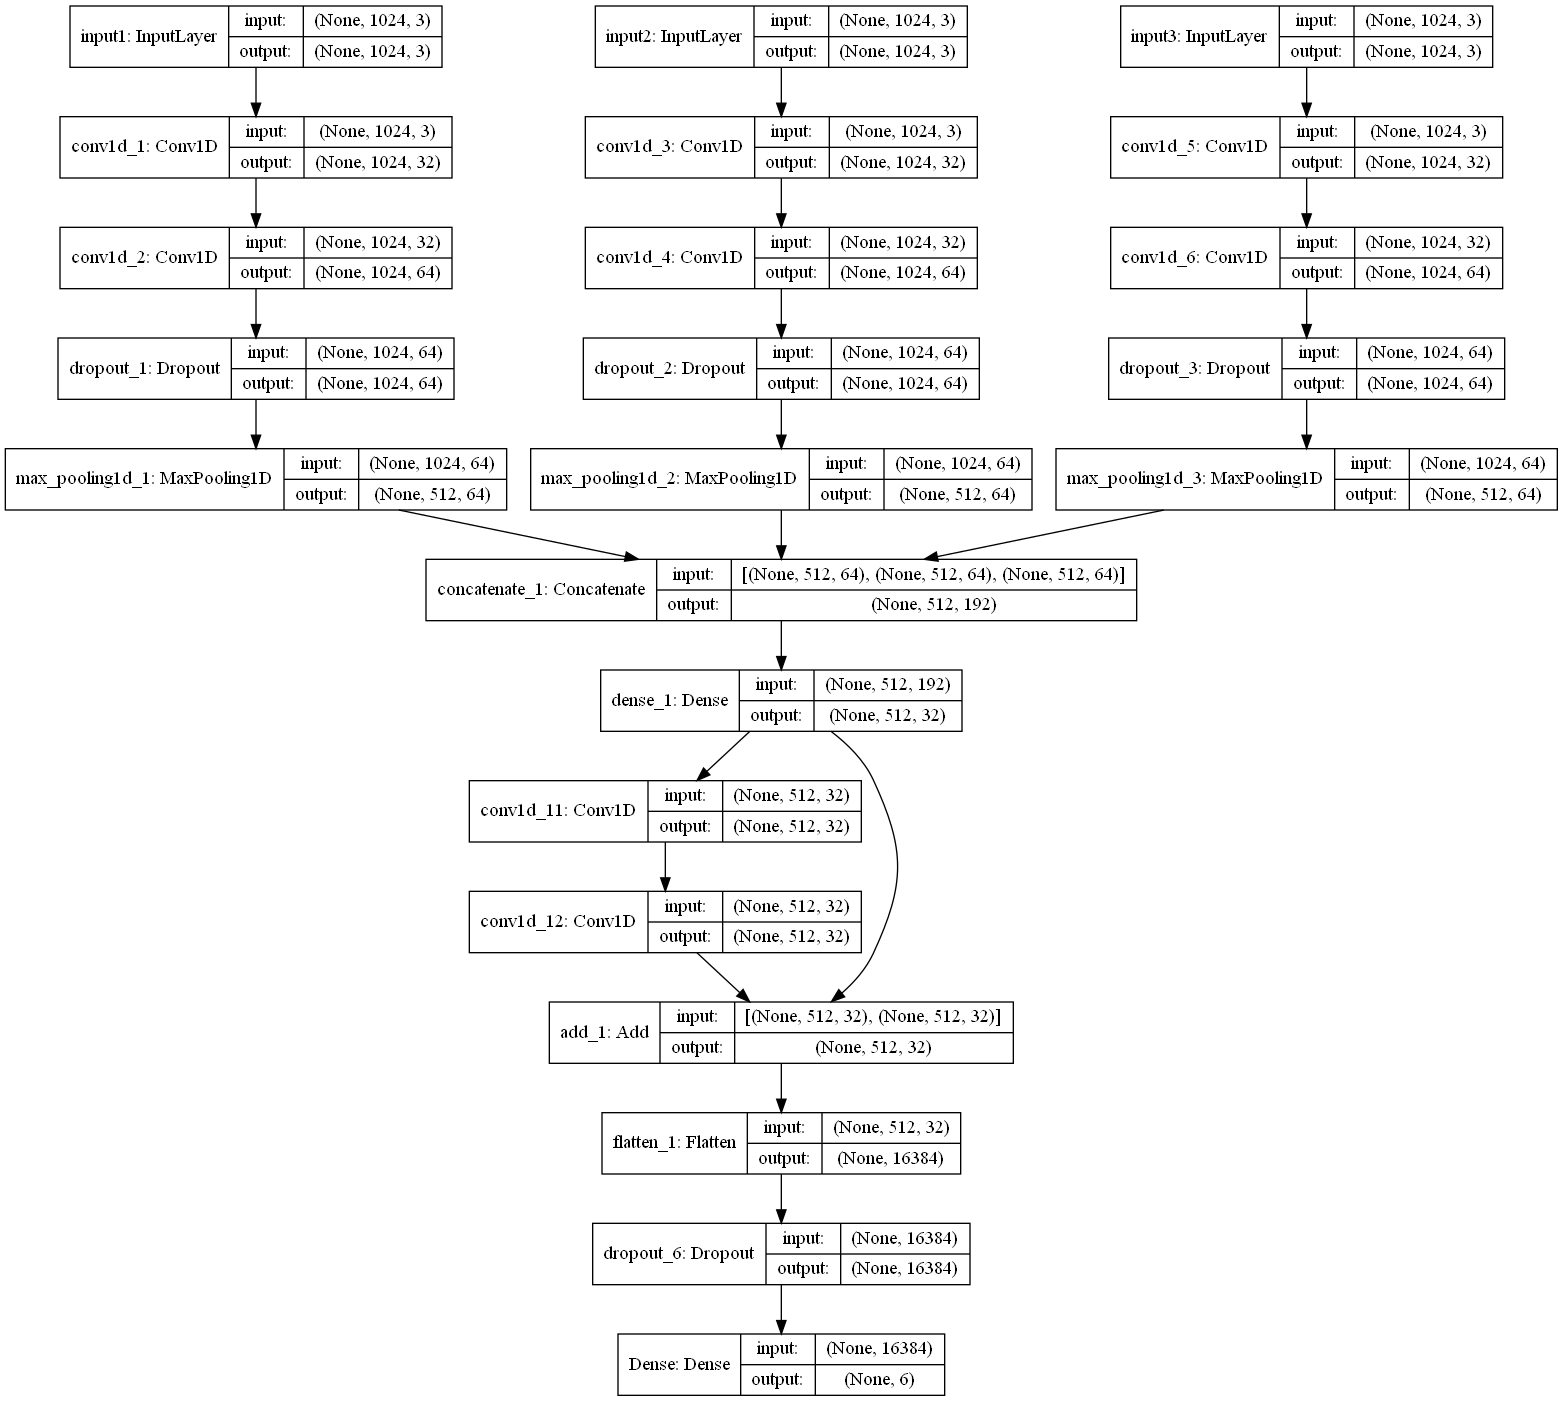

In [77]:
keras.utils.plot_model(merged_model,show_shapes = True)

In [78]:
predict_array = merged_model.predict([test_x2,test_x3,test_x5])
# 计算测试精度
y_predict = np.zeros_like(predict_array)
y_predict[np.arange(len(predict_array)), predict_array.argmax(axis=1)] = 1 #将每行最大值置1，最大值即为预测标签
temp = np.sum(abs(y_predict - one_hot_test_y), axis=1) #将y_predict与test_y相减，每一行取绝对值后相加，不为0的元素即为错误预测
temp[temp>0]=1 #将每一行中不为零的数置1
accuracy = (len(temp)-temp.sum())/len(temp)
print("Test accuracy is:", accuracy)

Test accuracy is: 0.9506666666666667


In [79]:
label = [np.argmax(item) for item in y_predict]
label
s=set()#定义集合|
for i in label:#循环列表中的元素
    if i not in s:#如果i不在集合中
        s.add(i)#将i添加到集合中
        print('Name:{}\tCount:{}'.format(i+1,label.count(i)))#格式化打印出i、i的count数

Name:3	Count:497
Name:1	Count:515
Name:4	Count:456
Name:2	Count:507
Name:6	Count:527
Name:5	Count:498


#### 绘制混淆矩阵

In [80]:
from pylab import mpl
font = {'family': 'FangSong_GB2312',
            'color': 'k',
            'weight': 'normal',
            'size': 6}
mpl.rcParams['font.family'] = 'FangSong_GB2312'

In [81]:
from matplotlib.colors import LinearSegmentedColormap

my_colormap = LinearSegmentedColormap.from_list("", ["#e9bf88", "#eb5656"])

In [82]:
from sklearn.metrics import confusion_matrix
def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)
    plt.figure(figsize=(14,14))
    plt.matshow(cm,cmap=plt.cm.RdPu)  #画混淆矩阵，配色风格为cm.Blues
    plt.colorbar()#标签颜色
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[y,x],xy=(x,y),horizontalalignment='center',verticalalignment='center',color='Salmon')
    plt.ylabel('真实标签',fontproperties = 'FangSong_GB2312')
    plt.xlabel('预测标签',fontproperties = 'FangSong_GB2312')

    plt.xticks(np.arange(0,6),['正常','轮齿折断','缺齿','齿面磨损','齿根裂纹','偏心轮'],rotation = 30,fontproperties = 'FangSong_GB2312', size = 10)
    plt.yticks(np.arange(0,6),['正常','轮齿折断','缺齿','齿面磨损','齿根裂纹','偏心轮'],rotation = 30,fontproperties = 'FangSong_GB2312', size = 10)
    plt.ylim(6-0.5,-0.5) 
#     plt.savefig('C:\\Users\\shamrockyj\\Desktop\\工况1的分类结果.png', dpi=300, bbox_inches='tight') 

<Figure size 1008x1008 with 0 Axes>

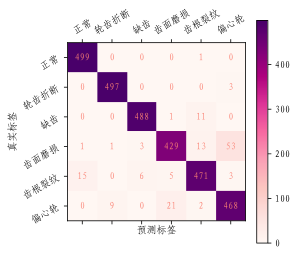

In [83]:
cm_plot(test_y,label)